In [ ]:
path = "/content/drive/MyDrive/BracU/Summer-21/AAI/Project"
from google.colab import drive
drive.mount("/content/drive")
%cd $path

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import datetime
import warnings
import itertools
from IPython.core.display import HTML
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import pickle
warnings.filterwarnings("ignore")

hmm.GMMHMM(n_components=1, n_mix=1, min_covar=0.001, startprob_prior=1.0, transmat_prior=1.0, weights_prior=1.0, means_prior=0.0, means_weight=0.0, covars_prior=None, covars_weight=None, algorithm='viterbi', covariance_type='diag', random_state=None, n_iter=10, tol=0.01, verbose=False, params='stmcw', init_params='stmcw')

In [54]:
company = 'ACI'
hmm = GaussianHMM(n_components=4, covariance_type='full', n_iter=10000, tol=0.001)

In [55]:
def load_dataset(company, test_size=0.2):
    data = pd.read_csv('./company_data/{company}.csv'.format(company=company))
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    test_data = test_data[::-1]
    print('Size of Dataset: {ds_size} -- Train Set: {tr_size} -- Test Set: {ts_size}'.
    format(ds_size=len(data), tr_size=len(train_data), ts_size=len(test_data)))

    display(HTML((data.describe()).to_html()))
    display(HTML((data.head(5)).to_html()))

    #print((data.head(5)).to_markdown(tablefmt='grid'))
    end_date = datetime.date.today()

    sample_data = data.head(100)
    plt.figure(figsize=(12, 5), dpi=80) 
    # + end_date.strftime("%m/%d/%Y"),
    plt.title(company + " - 100 Samples", fontsize = 14)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.gca().xaxis.set_minor_locator(MonthLocator())
    plt.plot_date(sample_data['date'],sample_data['open'],'-')
    plt.plot_date(sample_data['date'],sample_data['close'],'-')
    plt.plot_date(sample_data['date'],sample_data['high'],'-')
    plt.plot_date(sample_data['date'],sample_data['low'],'-')
    plt.legend(['Opening', 'Closing', 'Highest', 'Lowest'])
    plt.show()

    plt.figure(figsize=(12, 5), dpi=80) 
    # + end_date.strftime("%m/%d/%Y"),
    plt.title(company + " - Closing Price", fontsize = 14)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.plot_date(data['date'],data['close'],'-')
    plt.show()

    corr = data.corr(method='pearson', min_periods=1)
    #display(HTML((corr).to_html()))
    sns.heatmap(corr, annot=True,)
    
    return train_data,test_data

Size of Dataset: 3047 -- Train Set: 2437 -- Test Set: 610


,open,high,low,close,volume,prev_closing_price
count,3047.0000,3047.0000,3047.0000,3047.0000,3.0470e+03,3047.0000
mean,352.1059,356.0874,345.9961,351.9989,8.9902e+04,352.0779
std,137.2386,139.6657,136.4172,135.7671,1.2054e+05,135.6281
min,0.0000,0.0000,0.0000,0.0000,0.0000e+00,123.0000
25%,237.0500,240.6500,230.2000,240.3000,1.7922e+04,240.3000
50%,363.0000,366.0000,356.0000,363.5000,4.9050e+04,363.5000
75%,466.0500,474.0000,460.0000,465.4500,1.1175e+05,465.4500
max,650.0000,665.0000,619.0000,639.1000,1.2995e+06,639.1000


,date,open,high,low,close,volume,prev_closing_price
0,2008-03-06,200.0,202.0,194.0,195.5,266850,198.8
1,2008-03-09,199.8,199.8,194.0,195.0,333600,195.5
2,2008-03-09,199.8,199.8,194.0,195.0,333600,195.5
3,2008-03-10,196.5,209.5,195.4,207.3,381650,195.0
4,2008-03-11,209.9,217.9,207.0,215.5,509550,207.3


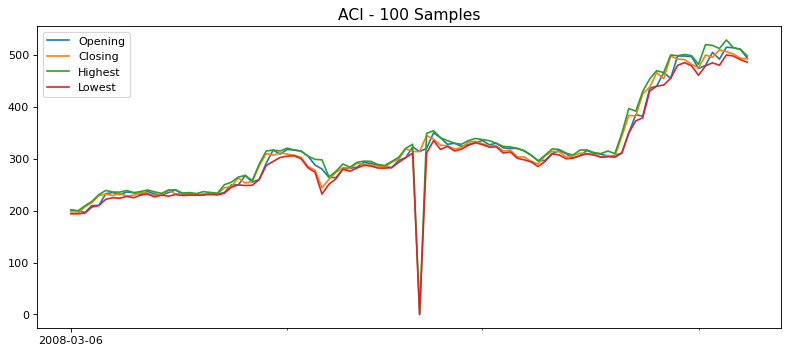

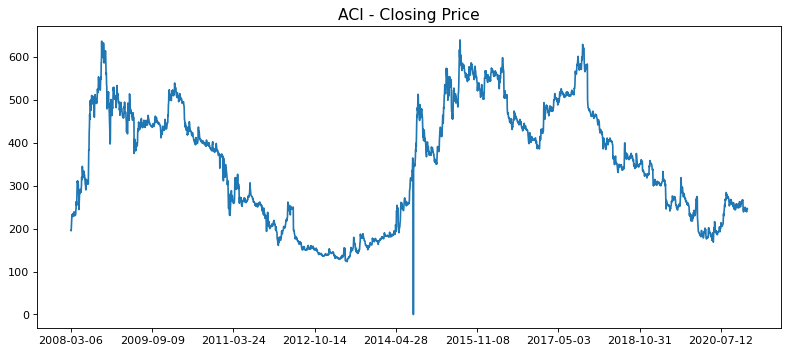

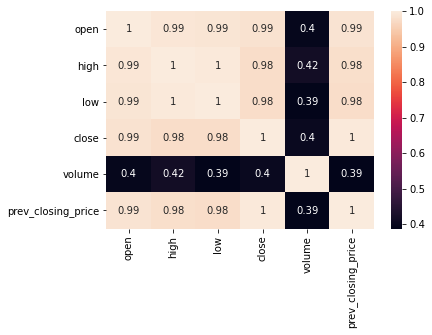

In [56]:
train_data, test_data = load_dataset(company)

In [57]:
def extract_features(data):
    open_price = np.array(data['open'])
    close_price = np.array(data['close'])
    high_price = np.array(data['high'])
    low_price = np.array(data['low'])

    frac_change = (close_price - open_price) / open_price
    frac_high = (high_price - open_price) / open_price
    frac_low = (open_price - low_price) / open_price

    return np.column_stack((frac_change, frac_high, frac_low))

In [58]:
def clean_dataset(data):
    df = pd.DataFrame(data)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [60]:
def fit(model, dataset):
    feature_vector = extract_features(dataset)
    print('Samples Before Cleaning:', len(feature_vector))
    data = clean_dataset(feature_vector)
    print('Samples After Cleaning:', len(data))

    feature_vector = data
    data.columns= ['FracChange', 'FracHigh','FracLow']
    display(HTML((data.head(5)).to_html()))

    feature_vector = data.to_numpy()
    model.fit(feature_vector)

In [61]:
fit(hmm,train_data)

#with open("{0}_ncomp_{1}_niter_{2}.pkl".format(company_code, model.n_components, model.n_iter), "wb") as file: pickle.dump(model, file)
#model = pickle.load(open("ACI_ncomp_20_niter_10000.pkl", 'rb'))


Samples Before Cleaning: 2437
Samples After Cleaning: 2433


,FracChange,FracHigh,FracLow
0,-0.0225,0.0100,0.0300
1,-0.0240,0.0000,0.0290
2,-0.0240,0.0000,0.0290
3,0.0550,0.0662,0.0056
4,0.0267,0.0381,0.0138


In [12]:
def compute_possible_outcomes(n_steps_frac_change=50, n_steps_frac_high=10, n_steps_frac_low=10):
    frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
    frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
    frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
    
    possible_outcomes = np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))
    return possible_outcomes

In [13]:
def get_most_probable_outcome(model, test_data, day_index, n_latency_days=30):
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_end_index: previous_data_start_index]
    previous_data_features = extract_features(previous_data)
    previous_data_features = (clean_dataset (previous_data_features)).to_numpy()
    outcome_score = []
    possible_outcomes = compute_possible_outcomes()
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((previous_data_features, possible_outcome))
        outcome_score.append(model.score(total_data))
    
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]
    return most_probable_outcome

In [14]:
def predict_close_price(model, test_data, day_index):
    open_price = test_data.iloc[day_index]['open']
    predicted_frac_change, _, _ = get_most_probable_outcome(model, test_data, day_index)
    return open_price * (1 + predicted_frac_change)

In [17]:
def predict_close_prices_series(model, test_data, days):
    predicted_close_prices = []
    for day_index in tqdm(range(days)):
        predicted_close_prices.append(predict_close_price(model, test_data, day_index))

    test_data = test_data[0: days]
    days = np.array(test_data['date'], dtype="datetime64[ms]")
    actual_close_prices = test_data['close']

    data = list(zip(days, actual_close_prices, predicted_close_prices))
    data =  pd.DataFrame(data, columns=['Date','Actual Price', 'Predicted Price'])
    data.reset_index(drop=True, inplace=True)
    #pd.set_option("display.precision", 1)
    data =  data.iloc[::-1]
    data.reset_index(drop=True, inplace=True)
    display(HTML(data.to_html()))

    plt.figure(figsize=(12, 5), dpi=80) 
    plt.title(company, fontsize = 14)
    plt.plot_date(days,actual_close_prices, 'o-')
    plt.plot_date(days,predicted_close_prices,'rx-')
    plt.legend(['Actual Price','Predicted Price'])
    plt.show()

    return data

100%|██████████| 20/20 [01:16<00:00,  3.85s/it]


,Date,Actual Price,Predicted Price
0,2020-12-02,244.3,246.994898
1,2020-12-03,242.2,243.801429
2,2020-12-06,238.8,242.504082
3,2020-12-07,245.5,238.512245
4,2020-12-08,247.2,245.996939
5,2020-12-09,245.1,244.599796
6,2020-12-10,245.2,244.699592
7,2020-12-13,245.0,245.497959
8,2020-12-14,245.3,244.998980
9,2020-12-15,249.7,243.601837


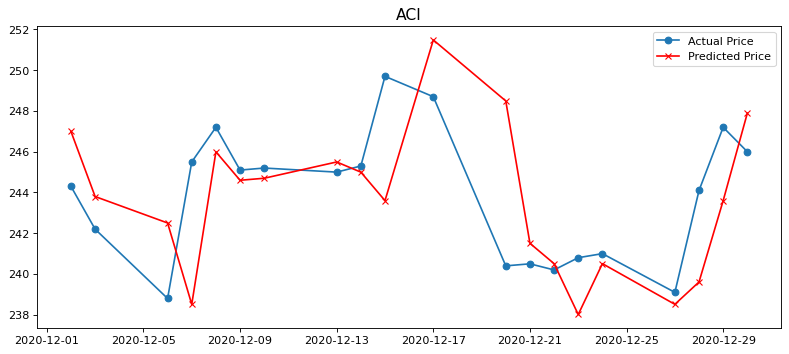

In [18]:
output = predict_close_prices_series(hmm, test_data, 20)

In [48]:
def eval_metrics(output):
    abs_diff = np.abs(output['Actual Price'] - output['Predicted Price'])

    MAE = np.mean(abs_diff)
    MSE = np.mean(abs_diff ** 2)
    RMSE = np.sqrt(MSE)
    #RMSLE = np.log(RMSE)
    #print("RMSLE: ", RMSLE)
    MAPE = np.mean((abs_diff*100/output['Actual Price']))

    metrices = [MAE, RMSE, MAPE]

    pd.set_option("display.precision", 4)
    metrices = pd.DataFrame(metrices, index =['MAE', 'RMSE', 'MAPE'], columns =['Score'])
    display(HTML(metrices.to_html()))

In [49]:
#indices_to_keep = ~output.isin([np.nan, np.inf, -np.inf, 0.0]).any(1)
#output = output [indices_to_keep]
eval_metrics(output)

,Score
MAE,2.5064
RMSE,3.4003
MAPE,1.0265


In [24]:
company = 'GP'
hmm_2 = GaussianHMM(n_components=4, covariance_type='full', n_iter=10000, tol=0.001)

Size of Dataset: 2638 -- Train Set: 2110 -- Test Set: 528


,open,high,low,close,volume,prev_closing_price
count,2638.0000,2638.0000,2638.0000,2638.0000,2.6380e+03,2638.0000
mean,279.9049,282.0676,275.5582,280.9817,5.0672e+05,280.9710
std,89.6559,91.7223,90.8107,87.8543,6.2442e+05,87.8439
min,0.0000,0.0000,0.0000,0.0000,0.0000e+00,10.0000
25%,205.0000,207.3500,202.0750,205.8000,1.5182e+05,205.8000
50%,272.0000,275.0000,267.6500,272.2000,3.1042e+05,272.2000
75%,340.6500,344.8750,337.0750,340.1750,6.1457e+05,340.1000
max,511.0000,513.1000,506.0000,510.7000,7.4926e+06,510.7000


,date,open,high,low,close,volume,prev_closing_price
0,2009-11-16,160.0,195.0,160.0,177.3,7430400,10.0
1,2009-11-17,176.1,186.0,170.1,171.1,2832800,177.3
2,2009-11-18,170.1,170.2,158.0,158.2,2732000,171.1
3,2009-11-19,158.1,167.9,152.0,164.0,1627200,158.2
4,2009-11-22,167.0,168.9,163.0,165.7,872400,164.0


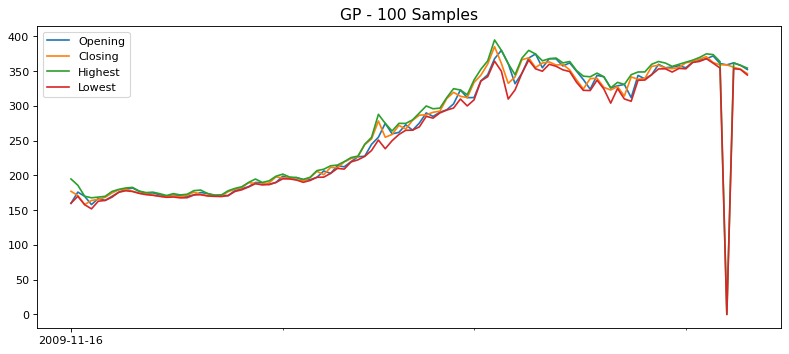

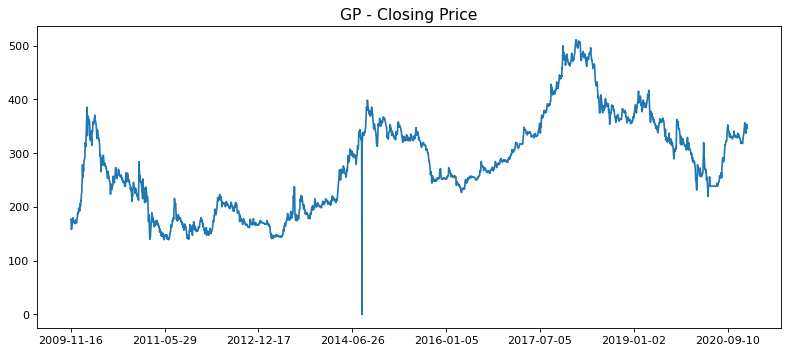

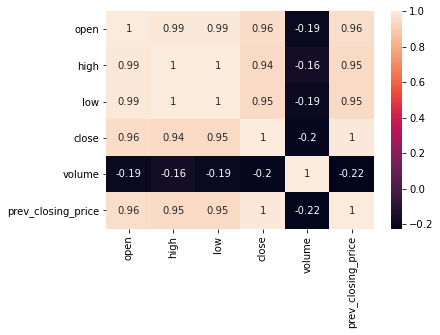

In [25]:
train_data_2, test_data_2 = load_dataset(company)

In [27]:
fit(hmm_2,train_data_2)


Samples Before Cleaning: 2110
Samples After Cleaning: 2101


,FracChange,FracHigh,FracLow
0,0.1081,0.2188,0.0000
1,-0.0284,0.0562,0.0341
2,-0.0700,0.0006,0.0711
3,0.0373,0.0620,0.0386
4,-0.0078,0.0114,0.0240


100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


,Date,Actual Price,Predicted Price
0,2020-12-02,318.0,323.3663
1,2020-12-03,319.4,321.2449
2,2020-12-06,326.1,323.3663
3,2020-12-07,328.8,328.4173
4,2020-12-08,334.1,331.1449
5,2020-12-09,334.9,337.5092
6,2020-12-10,341.5,338.3173
7,2020-12-13,345.5,346.5000
8,2020-12-14,350.2,349.5306
9,2020-12-15,356.8,354.5816


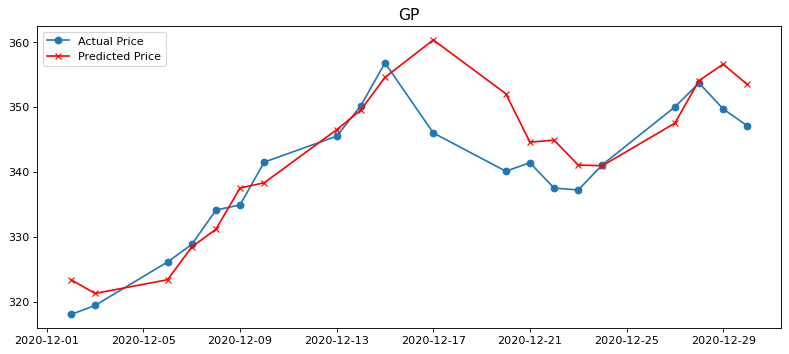

In [33]:
output_2 = predict_close_prices_series(hmm_2, test_data_2, 20)

In [35]:
eval_metrics(output_2)

,Score
MAE,3.9981
RMSE,5.4518
MAPE,1.1755
